This notebook uses the method described in [Alexandru Papiu](https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import skew
from scipy.stats.stats import pearsonr


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
train = pd.read_csv('original_data/train.csv')
labels = train["SalePrice"]
test = pd.read_csv('original_data/test.csv')
data = pd.concat([train,test],ignore_index=True)
data = data.drop(['SalePrice', 'Id'], 1)
ids = test["Id"]

# Data preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1099b3cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10a0817f0>]], dtype=object)

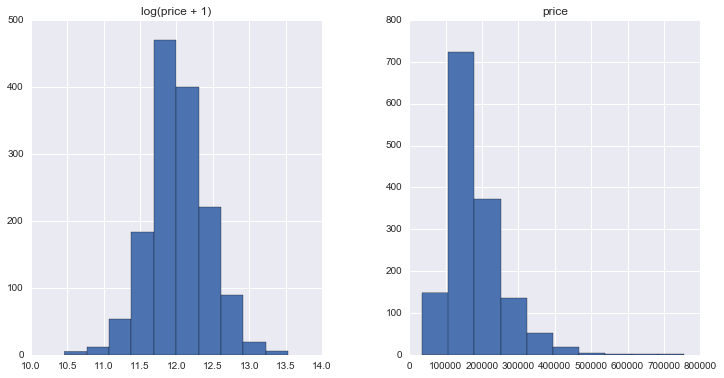

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

## Transform the label

In [4]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

## Transform the training data

In [5]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

In [6]:
data = pd.get_dummies(data)

In [7]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.000000,5.017280,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,0.693147,5.652489,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.000000,6.075346,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.000000,6.293419,5.609472,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.000000,6.196444,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [8]:
#filling NA's with the mean of the column:
data = data.fillna(data.mean())

In [9]:
#creating matrices for sklearn:
X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
y = train.SalePrice

# Model

## Ridge

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge()

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

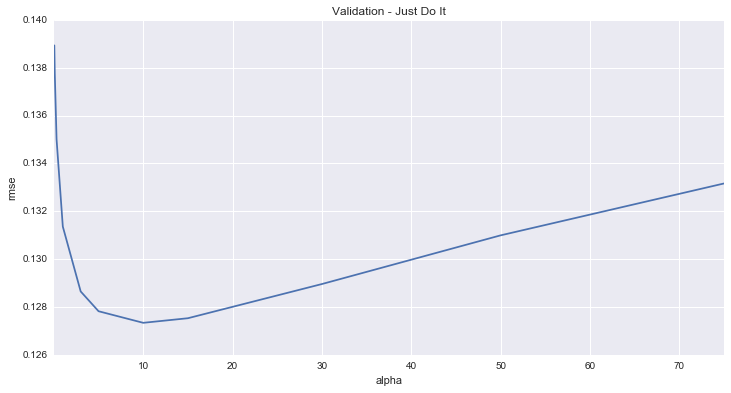

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

## Lasso

In [14]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [15]:
rmse_cv(model_lasso).mean()

0.12314362108001491

In [16]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [17]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [18]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [19]:
imp_coef

RoofMatl_ClyTile        -0.704137
MSZoning_C (all)        -0.292022
Condition2_PosN         -0.190544
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047118
MSZoning_RM             -0.037696
CentralAir_N            -0.035440
GarageCond_Fa           -0.031687
LandContour_Bnk         -0.030934
SaleType_WD             -0.030657
OverallQual              0.053160
KitchenQual_Ex           0.063712
Exterior1st_BrkFace      0.070463
Neighborhood_NridgHt     0.071621
LotArea                  0.071824
Functional_Typ           0.072596
Neighborhood_NoRidge     0.085718
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112495
GrLivArea                0.400027
dtype: float64

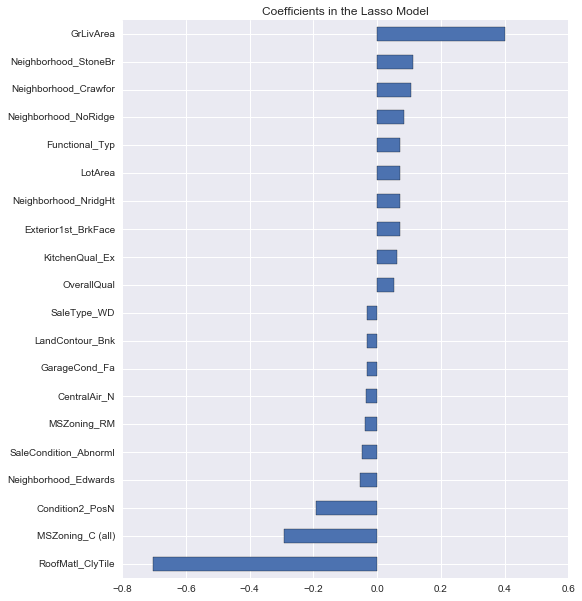

In [20]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [21]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [22]:
solution = pd.DataFrame({"Id":test.Id, "SalePrice": lasso_preds})
#solution.to_csv("submit/xgb.csv", index = False)
filename = os.path.join('lasso' + ".csv")
solution.to_csv('submit/' + filename, index=False)

## XGBoost 

In [23]:
import xgboost as xgb

In [24]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [25]:
model

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,10.380138,0.007834,10.380139,0.003413
1,9.344810,0.008219,9.344813,0.003153
2,8.413089,0.008584,8.413092,0.002927
3,7.574992,0.008599,7.574618,0.002707
4,6.820292,0.008262,6.819935,0.002493
5,6.140506,0.008449,6.140691,0.002305
6,5.529961,0.007377,5.529318,0.002142
7,4.979715,0.007124,4.979068,0.001986
8,4.484608,0.007024,4.483856,0.001864
9,4.039001,0.006651,4.038170,0.001761


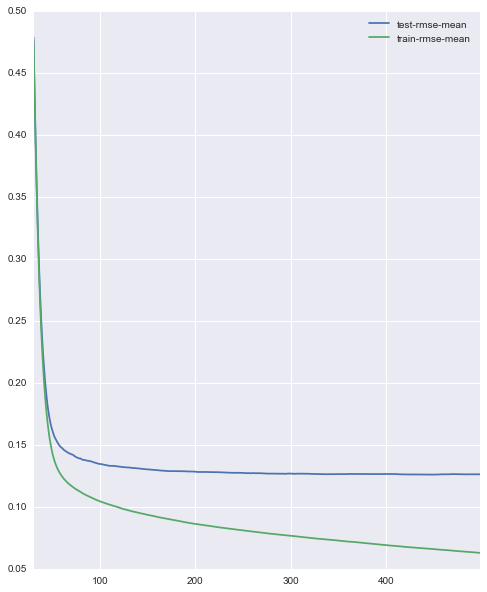

In [26]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [27]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [28]:
xgb_preds = np.expm1(model_xgb.predict(X_test)) # inverse of log(1 + x)

In [29]:
solution = pd.DataFrame({"Id":test.Id, "SalePrice": xgb_preds})
#solution.to_csv("submit/xgb.csv", index = False)
filename = os.path.join('xgboost' + ".csv")
solution.to_csv('submit/' + filename, index=False)

In [30]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [31]:
solution = pd.DataFrame({"Id":test.Id, "SalePrice": preds})
#solution.to_csv("submit/xgb.csv", index = False)
filename = os.path.join('lasso_xgb' + ".csv")
solution.to_csv('submit/' + filename, index=False)